# DR-MoEViT-UNet: Google Drive Version
## Colorectal Cancer Segmentation with Vision Transformer + Mixture of Experts

**Same as original, but saves to Google Drive!**
- Google Drive mount at start
- Checkpoints saved to Drive (safe even if runtime crashes)
- Resume capability from Drive checkpoints

In [1]:
# Cell 1: Mount Google Drive + Download Dataset
!pip install -q kagglehub

# Mount Google Drive FIRST
from google.colab import drive
drive.mount('/content/drive')

import kagglehub
import os

# Verify Drive is mounted
if not os.path.exists('/content/drive/MyDrive'):
    raise Exception("Drive not mounted!")
print("✅ Google Drive mounted!")

# Download dataset
path = kagglehub.dataset_download('orvile/ebhi-seg-colorectal-cancer')
print(f'Dataset downloaded to: {path}')

# Auto-detect correct data directory
subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
expected_classes = ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp', 'Serrated adenoma']
DATA_DIR = path
for subdir in subdirs:
    subdir_path = os.path.join(path, subdir)
    if os.path.isdir(subdir_path):
        sub_contents = os.listdir(subdir_path)
        if any(cls in sub_contents for cls in expected_classes):
            DATA_DIR = subdir_path
            break

print(f'Using DATA_DIR: {DATA_DIR}')

# Checkpoint directory - SAVES TO GOOGLE DRIVE!
CHECKPOINT_DIR = '/content/drive/MyDrive/FYP_Checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f'✅ Checkpoints will be saved to: {CHECKPOINT_DIR}')

# Verify dataset
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(f'Found {len(classes)} classes: {classes}')


Mounted at /content/drive
✅ Google Drive mounted!


100%|██████████| 264M/264M [00:12<00:00, 21.9MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/orvile/ebhi-seg-colorectal-cancer/versions/1
Using DATA_DIR: /root/.cache/kagglehub/datasets/orvile/ebhi-seg-colorectal-cancer/versions/1/EBHI-SEG
✅ Checkpoints will be saved to: /content/drive/MyDrive/FYP_Checkpoints
Found 6 classes: ['Normal', 'High-grade IN', 'Low-grade IN', 'Serrated adenoma', 'Polyp', 'Adenocarcinoma']


In [2]:
import os

base = "/root/.cache/kagglehub/datasets/orvile/ebhi-seg-colorectal-cancer/versions/1/EBHI-SEG"

for root, dirs, files in os.walk(base, topdown=True):
    print(root, dirs, files[:10])
    break


/root/.cache/kagglehub/datasets/orvile/ebhi-seg-colorectal-cancer/versions/1/EBHI-SEG ['Normal', 'High-grade IN', 'Low-grade IN', 'Serrated adenoma', 'Polyp', 'Adenocarcinoma'] ['readme.md']


In [3]:
# Cell 2: Imports and Configuration
import os
import sys
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
import seaborn as sns
import json
import time

# Configuration
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-4
IMG_SIZE = 256
NUM_CLASSES = 6
RESUME_TRAINING = True  # Set to True to resume from checkpoint

# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


In [4]:
# Cell 3: Set Random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# Cell 4: Dataset Class
class ColorectalCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN',
                           'Normal', 'Polyp', 'Serrated adenoma']
        self.samples = []

        for class_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(root_dir, class_name)
            image_dir = os.path.join(class_dir, 'image')
            mask_dir = os.path.join(class_dir, 'label')

            if os.path.exists(image_dir):
                image_files = os.listdir(image_dir)
                for img_file in image_files:
                    img_path = os.path.join(image_dir, img_file)
                    mask_path = os.path.join(mask_dir, img_file)
                    if os.path.exists(mask_path):
                        self.samples.append({
                            'image_path': img_path,
                            'mask_path': mask_path,
                            'class_idx': class_idx,
                            'class_name': class_name
                        })
        print(f'Total samples loaded: {len(self.samples)}')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['image_path']).convert('RGB')
        mask = Image.open(sample['mask_path']).convert('L')

        if self.transform:
            seed = np.random.randint(2147483647)
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transform(image)
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        mask = (mask > 0.5).float()
        return {
            'image': image,
            'mask': mask,
            'class_idx': torch.tensor(sample['class_idx'], dtype=torch.long),
            'class_name': sample['class_name']
        }

In [6]:
# Cell 5: Data Transforms and Loaders
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def load_dataset(data_dir):
    full_dataset = ColorectalCancerDataset(root_dir=data_dir, transform=transform)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(
        full_dataset, [train_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader, train_dataset, test_dataset

train_loader, test_loader, train_dataset, test_dataset = load_dataset(DATA_DIR)

Total samples loaded: 2226
Train: 1780, Test: 446


In [7]:
# Cell 6: Model Architecture - Patch Embedding & Attention
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x), attn

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, attn = self.attn(self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x, attn

In [8]:
# Cell 7: Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3,
                 embed_dim=768, depth=12, num_heads=12, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.blocks = nn.ModuleList([TransformerEncoder(embed_dim, num_heads, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1) + self.pos_embed
        attentions = []
        for block in self.blocks:
            x, attn = block(x)
            attentions.append(attn)
        return self.norm(x), attentions

In [9]:
# Cell 8: MoE Components
class ExpertModule(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1), nn.BatchNorm2d(mid_ch), nn.ReLU(True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True)
        )
    def forward(self, x): return self.conv(x)

class DynamicRouter(nn.Module):
    def __init__(self, channels, num_experts):
        super().__init__()
        self.router = nn.Sequential(
            nn.Conv2d(channels, channels//2, 3, padding=1), nn.BatchNorm2d(channels//2), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(channels//2, num_experts), nn.Softmax(dim=1)
        )
    def forward(self, x): return self.router(x)

class MixtureOfExperts(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, num_experts=4):
        super().__init__()
        self.experts = nn.ModuleList([ExpertModule(in_ch, mid_ch, out_ch) for _ in range(num_experts)])
        self.router = DynamicRouter(in_ch, num_experts)

    def forward(self, x):
        weights = self.router(x)
        outputs = torch.stack([e(x) for e in self.experts], dim=1)
        weights = weights.view(x.size(0), len(self.experts), 1, 1, 1)
        return (outputs * weights).sum(dim=1), weights.squeeze()

In [10]:
# Cell 9: Decoder and Auxiliary Classifier
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(True)
        )
    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None: x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(in_ch, 256), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.net(x)

In [11]:
# Cell 10: Complete MoEViTUNet Model
class MoEViTUNet(nn.Module):
    def __init__(self, img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12, num_classes=6, num_experts=4):
        super().__init__()
        self.vit = VisionTransformer(img_size, patch_size, 3, embed_dim, depth, num_heads)
        self.patch_size, self.embed_dim = patch_size, embed_dim
        dims = [256, 128, 64, 32]
        self.conv_transform = nn.Conv2d(embed_dim, dims[0], 1)
        self.moe1 = MixtureOfExperts(dims[0], dims[0], dims[0], num_experts)
        self.moe2 = MixtureOfExperts(dims[0], dims[0], dims[1], num_experts)
        self.moe3 = MixtureOfExperts(dims[1], dims[1], dims[2], num_experts)
        self.moe4 = MixtureOfExperts(dims[2], dims[2], dims[3], num_experts)
        self.decoder1 = DecoderBlock(dims[0], dims[1])
        self.decoder2 = DecoderBlock(dims[1]*2, dims[2])
        self.decoder3 = DecoderBlock(dims[2]*2, dims[3])
        self.decoder4 = DecoderBlock(dims[3], dims[3])
        self.aux1 = AuxiliaryClassifier(dims[0], num_classes)
        self.aux2 = AuxiliaryClassifier(dims[1], num_classes)
        self.aux3 = AuxiliaryClassifier(dims[2], num_classes)
        self.aux4 = AuxiliaryClassifier(dims[3], num_classes)
        self.final_conv = nn.Conv2d(dims[3], 1, 1)
        self.main_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(dims[3], 256), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        vit_out, attns = self.vit(x)
        feat = vit_out[:, 1:, :]
        h = w = int(np.sqrt(feat.shape[1]))
        feat = feat.reshape(feat.shape[0], h, w, self.embed_dim).permute(0, 3, 1, 2)
        x0 = self.conv_transform(feat)
        x1, w1 = self.moe1(x0)
        x2, w2 = self.moe2(x1)
        x3, w3 = self.moe3(x2)
        x4, w4 = self.moe4(x3)
        d1 = self.decoder1(x1)
        x2_r = F.interpolate(x2, size=d1.shape[2:], mode='bilinear', align_corners=True) if d1.shape[2:] != x2.shape[2:] else x2
        d2 = self.decoder2(torch.cat([d1, x2_r], dim=1))
        x3_r = F.interpolate(x3, size=d2.shape[2:], mode='bilinear', align_corners=True) if d2.shape[2:] != x3.shape[2:] else x3
        d3 = self.decoder3(torch.cat([d2, x3_r], dim=1))
        d4 = self.decoder4(d3)
        d4_up = F.interpolate(d4, size=x.shape[2:], mode='bilinear', align_corners=True)
        return {
            'mask': torch.sigmoid(self.final_conv(d4_up)),
            'main_class': self.main_classifier(d4),
            'aux1': self.aux1(x1), 'aux2': self.aux2(x2), 'aux3': self.aux3(x3), 'aux4': self.aux4(x4),
            'attentions': attns, 'moe_weights': [w1, w2, w3, w4]
        }

In [12]:
# Cell 11: Loss Functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, pred, target):
        pred, target = pred.view(-1), target.view(-1)
        intersection = (pred * target).sum()
        return 1 - (2 * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0): super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, pred, target):
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        return (self.alpha * ((1 - torch.exp(-bce)) ** self.gamma) * bce).mean()

class MultiTaskLoss(nn.Module):
    def __init__(self, seg_w=1.0, cls_w=0.5, aux_w=0.3):
        super().__init__()
        self.seg_w, self.cls_w, self.aux_w = seg_w, cls_w, aux_w
        self.dice, self.focal, self.ce = DiceLoss(), FocalLoss(), nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        seg = self.dice(outputs['mask'], targets['mask']) + self.focal(outputs['mask'], targets['mask'])
        cls = self.ce(outputs['main_class'], targets['class_idx'])
        aux = sum(self.ce(outputs[f'aux{i}'], targets['class_idx']) for i in range(1,5)) / 4
        total = self.seg_w * seg + self.cls_w * cls + self.aux_w * aux
        return total, {'total': total.item(), 'seg': seg.item(), 'cls': cls.item(), 'aux': aux.item()}

In [13]:
# Cell 12: Metrics Calculation
def calculate_metrics(pred_masks, true_masks, threshold=0.5):
    pred = (pred_masks > threshold).float().cpu().numpy().reshape(-1)
    true = true_masks.cpu().numpy().reshape(-1)
    return {
        'accuracy': accuracy_score(true, pred),
        'precision': precision_score(true, pred, zero_division=0),
        'recall': recall_score(true, pred, zero_division=0),
        'f1_score': f1_score(true, pred, zero_division=0),
        'iou': jaccard_score(true, pred, zero_division=0),
        'specificity': ((1-pred) * (1-true)).sum() / max(((1-true)).sum(), 1)
    }

In [14]:
# Cell 13: Enhanced Training Function with Per-Epoch Checkpointing
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, save_dir, resume_from=None):
    os.makedirs(save_dir, exist_ok=True)
    start_epoch = 0
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_metrics': [], 'val_metrics': [], 'lr': []}

    # Resume from checkpoint
    latest_ckpt = os.path.join(save_dir, 'latest_checkpoint.pth')
    if resume_from and os.path.exists(latest_ckpt):
        print(f'Resuming from checkpoint: {latest_ckpt}')
        ckpt = torch.load(latest_ckpt)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        if scheduler and ckpt.get('scheduler_state_dict'):
            scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        start_epoch = ckpt['epoch'] + 1
        history = ckpt['history']
        best_val_loss = ckpt['best_val_loss']
        print(f'Resumed from epoch {start_epoch}')

    for epoch in range(start_epoch, epochs):
        model.train()
        epoch_loss, epoch_metrics = 0, {k: 0 for k in ['accuracy','precision','recall','f1_score','iou','specificity']}

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, masks, class_idx = batch['image'].to(device), batch['mask'].to(device), batch['class_idx'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss, loss_dict = criterion(outputs, {'mask': masks, 'class_idx': class_idx})
            loss.backward()
            optimizer.step()
            epoch_loss += loss_dict['total']
            m = calculate_metrics(outputs['mask'].detach(), masks)
            for k in epoch_metrics: epoch_metrics[k] += m[k]

        epoch_loss /= len(train_loader)
        for k in epoch_metrics: epoch_metrics[k] /= len(train_loader)
        history['train_loss'].append(epoch_loss)
        history['train_metrics'].append(epoch_metrics.copy())
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss, val_metrics = 0, {k: 0 for k in epoch_metrics}
        with torch.no_grad():
            for batch in val_loader:
                images, masks, class_idx = batch['image'].to(device), batch['mask'].to(device), batch['class_idx'].to(device)
                outputs = model(images)
                loss, loss_dict = criterion(outputs, {'mask': masks, 'class_idx': class_idx})
                val_loss += loss_dict['total']
                m = calculate_metrics(outputs['mask'], masks)
                for k in val_metrics: val_metrics[k] += m[k]
        val_loss /= len(val_loader)
        for k in val_metrics: val_metrics[k] /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_metrics'].append(val_metrics.copy())

        print(f'Epoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {epoch_metrics["iou"]:.4f}, Val IoU: {val_metrics["iou"]:.4f}')

        # Save latest checkpoint (overwritten each epoch) and best model
        ckpt = {
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'history': history, 'best_val_loss': min(best_val_loss, val_loss)
        }
        torch.save(ckpt, latest_ckpt)  # ← Only this line now (overwrites each epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(ckpt, os.path.join(save_dir, 'best_model.pth'))
            print(f'Best model saved with Val Loss: {val_loss:.4f}')

        if scheduler: scheduler.step()

    return model, history

In [15]:
# Cell 14: Initialize Model and Training Components
model = MoEViTUNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES).to(DEVICE)
criterion = MultiTaskLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

Total parameters: 96,936,047
Trainable parameters: 96,936,047


In [16]:
# Cell 15: Train the Model
model, history = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler,
    DEVICE, EPOCHS, CHECKPOINT_DIR, resume_from=RESUME_TRAINING
)

Epoch 1/50: 100%|██████████| 111/111 [02:22<00:00,  1.29s/it]


Epoch 1 - Train Loss: 1.8085, Val Loss: 1.7487, Train IoU: 0.6070, Val IoU: 0.5661
Best model saved with Val Loss: 1.7487


Epoch 2/50: 100%|██████████| 111/111 [02:21<00:00,  1.28s/it]


Epoch 2 - Train Loss: 1.4652, Val Loss: 1.4711, Train IoU: 0.6852, Val IoU: 0.6479
Best model saved with Val Loss: 1.4711


Epoch 3/50: 100%|██████████| 111/111 [02:27<00:00,  1.33s/it]


Epoch 3 - Train Loss: 1.2552, Val Loss: 2.1402, Train IoU: 0.7253, Val IoU: 0.6220


Epoch 4/50: 100%|██████████| 111/111 [02:26<00:00,  1.32s/it]


Epoch 4 - Train Loss: 1.1313, Val Loss: 1.2905, Train IoU: 0.7396, Val IoU: 0.7320
Best model saved with Val Loss: 1.2905


Epoch 5/50: 100%|██████████| 111/111 [02:29<00:00,  1.34s/it]


Epoch 5 - Train Loss: 1.0395, Val Loss: 1.6040, Train IoU: 0.7494, Val IoU: 0.7028


Epoch 6/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 6 - Train Loss: 0.9767, Val Loss: 1.9552, Train IoU: 0.7580, Val IoU: 0.7083


Epoch 7/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 7 - Train Loss: 0.9282, Val Loss: 1.0075, Train IoU: 0.7638, Val IoU: 0.7551
Best model saved with Val Loss: 1.0075


Epoch 8/50: 100%|██████████| 111/111 [02:28<00:00,  1.34s/it]


Epoch 8 - Train Loss: 0.8852, Val Loss: 1.8096, Train IoU: 0.7716, Val IoU: 0.7094


Epoch 9/50: 100%|██████████| 111/111 [02:26<00:00,  1.32s/it]


Epoch 9 - Train Loss: 0.8284, Val Loss: 1.3871, Train IoU: 0.7737, Val IoU: 0.7451


Epoch 10/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 10 - Train Loss: 0.7867, Val Loss: 1.5850, Train IoU: 0.7797, Val IoU: 0.7426


Epoch 11/50: 100%|██████████| 111/111 [02:24<00:00,  1.31s/it]


Epoch 11 - Train Loss: 0.7628, Val Loss: 0.9385, Train IoU: 0.7807, Val IoU: 0.7644
Best model saved with Val Loss: 0.9385


Epoch 12/50: 100%|██████████| 111/111 [02:29<00:00,  1.35s/it]


Epoch 12 - Train Loss: 0.7041, Val Loss: 1.2464, Train IoU: 0.7870, Val IoU: 0.7579


Epoch 13/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 13 - Train Loss: 0.6725, Val Loss: 1.0474, Train IoU: 0.7901, Val IoU: 0.7504


Epoch 14/50: 100%|██████████| 111/111 [02:23<00:00,  1.30s/it]


Epoch 14 - Train Loss: 0.6560, Val Loss: 1.5043, Train IoU: 0.7939, Val IoU: 0.7730


Epoch 15/50: 100%|██████████| 111/111 [02:24<00:00,  1.31s/it]


Epoch 15 - Train Loss: 0.6451, Val Loss: 1.0078, Train IoU: 0.7947, Val IoU: 0.7757


Epoch 16/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 16 - Train Loss: 0.6058, Val Loss: 1.4221, Train IoU: 0.7994, Val IoU: 0.7749


Epoch 17/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 17 - Train Loss: 0.5790, Val Loss: 1.1300, Train IoU: 0.8036, Val IoU: 0.7643


Epoch 18/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 18 - Train Loss: 0.5299, Val Loss: 1.0454, Train IoU: 0.8085, Val IoU: 0.7743


Epoch 19/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 19 - Train Loss: 0.5913, Val Loss: 1.0735, Train IoU: 0.8021, Val IoU: 0.7824


Epoch 20/50: 100%|██████████| 111/111 [02:23<00:00,  1.30s/it]


Epoch 20 - Train Loss: 0.5262, Val Loss: 1.4642, Train IoU: 0.8113, Val IoU: 0.7726


Epoch 21/50: 100%|██████████| 111/111 [02:23<00:00,  1.30s/it]


Epoch 21 - Train Loss: 0.5081, Val Loss: 1.3390, Train IoU: 0.8124, Val IoU: 0.7808


Epoch 22/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 22 - Train Loss: 0.4744, Val Loss: 1.1148, Train IoU: 0.8170, Val IoU: 0.7902


Epoch 23/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 23 - Train Loss: 0.4401, Val Loss: 1.0397, Train IoU: 0.8215, Val IoU: 0.7800


Epoch 24/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 24 - Train Loss: 0.4280, Val Loss: 1.2560, Train IoU: 0.8198, Val IoU: 0.7821


Epoch 25/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 25 - Train Loss: 0.4141, Val Loss: 1.0499, Train IoU: 0.8238, Val IoU: 0.7818


Epoch 26/50: 100%|██████████| 111/111 [02:23<00:00,  1.29s/it]


Epoch 26 - Train Loss: 0.4104, Val Loss: 1.8576, Train IoU: 0.8249, Val IoU: 0.7655


Epoch 27/50: 100%|██████████| 111/111 [02:23<00:00,  1.29s/it]


Epoch 27 - Train Loss: 0.3909, Val Loss: 1.1209, Train IoU: 0.8304, Val IoU: 0.7994


Epoch 28/50: 100%|██████████| 111/111 [02:23<00:00,  1.30s/it]


Epoch 28 - Train Loss: 0.3815, Val Loss: 1.0709, Train IoU: 0.8324, Val IoU: 0.7943


Epoch 29/50: 100%|██████████| 111/111 [02:23<00:00,  1.29s/it]


Epoch 29 - Train Loss: 0.3362, Val Loss: 1.0635, Train IoU: 0.8374, Val IoU: 0.8010


Epoch 30/50: 100%|██████████| 111/111 [02:23<00:00,  1.30s/it]


Epoch 30 - Train Loss: 0.3350, Val Loss: 1.0867, Train IoU: 0.8383, Val IoU: 0.7980


Epoch 31/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 31 - Train Loss: 0.3085, Val Loss: 1.0400, Train IoU: 0.8448, Val IoU: 0.7883


Epoch 32/50: 100%|██████████| 111/111 [02:26<00:00,  1.32s/it]


Epoch 32 - Train Loss: 0.3082, Val Loss: 1.2375, Train IoU: 0.8473, Val IoU: 0.7893


Epoch 33/50: 100%|██████████| 111/111 [02:24<00:00,  1.31s/it]


Epoch 33 - Train Loss: 0.3068, Val Loss: 1.2162, Train IoU: 0.8502, Val IoU: 0.8042


Epoch 34/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 34 - Train Loss: 0.2847, Val Loss: 1.0974, Train IoU: 0.8524, Val IoU: 0.8042


Epoch 35/50: 100%|██████████| 111/111 [02:24<00:00,  1.31s/it]


Epoch 35 - Train Loss: 0.2752, Val Loss: 1.0989, Train IoU: 0.8563, Val IoU: 0.8078


Epoch 36/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 36 - Train Loss: 0.2543, Val Loss: 1.1342, Train IoU: 0.8587, Val IoU: 0.8057


Epoch 37/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 37 - Train Loss: 0.2460, Val Loss: 1.1151, Train IoU: 0.8622, Val IoU: 0.8065


Epoch 38/50: 100%|██████████| 111/111 [02:26<00:00,  1.32s/it]


Epoch 38 - Train Loss: 0.2501, Val Loss: 1.1300, Train IoU: 0.8644, Val IoU: 0.8109


Epoch 39/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 39 - Train Loss: 0.2389, Val Loss: 1.1126, Train IoU: 0.8660, Val IoU: 0.8106


Epoch 40/50: 100%|██████████| 111/111 [02:23<00:00,  1.29s/it]


Epoch 40 - Train Loss: 0.2387, Val Loss: 1.1938, Train IoU: 0.8684, Val IoU: 0.8108


Epoch 41/50: 100%|██████████| 111/111 [02:24<00:00,  1.31s/it]


Epoch 41 - Train Loss: 0.2262, Val Loss: 1.1198, Train IoU: 0.8711, Val IoU: 0.8083


Epoch 42/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 42 - Train Loss: 0.2296, Val Loss: 1.2241, Train IoU: 0.8720, Val IoU: 0.8112


Epoch 43/50: 100%|██████████| 111/111 [02:27<00:00,  1.33s/it]


Epoch 43 - Train Loss: 0.2289, Val Loss: 1.1640, Train IoU: 0.8726, Val IoU: 0.8121


Epoch 44/50: 100%|██████████| 111/111 [02:26<00:00,  1.32s/it]


Epoch 44 - Train Loss: 0.2210, Val Loss: 1.1512, Train IoU: 0.8737, Val IoU: 0.8090


Epoch 45/50: 100%|██████████| 111/111 [02:27<00:00,  1.33s/it]


Epoch 45 - Train Loss: 0.2264, Val Loss: 1.1367, Train IoU: 0.8749, Val IoU: 0.8077


Epoch 46/50: 100%|██████████| 111/111 [02:25<00:00,  1.31s/it]


Epoch 46 - Train Loss: 0.2205, Val Loss: 1.1688, Train IoU: 0.8761, Val IoU: 0.8108


Epoch 47/50: 100%|██████████| 111/111 [02:26<00:00,  1.32s/it]


Epoch 47 - Train Loss: 0.2186, Val Loss: 1.1166, Train IoU: 0.8763, Val IoU: 0.8116


Epoch 48/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 48 - Train Loss: 0.2125, Val Loss: 1.1727, Train IoU: 0.8782, Val IoU: 0.8098


Epoch 49/50: 100%|██████████| 111/111 [02:24<00:00,  1.31s/it]


Epoch 49 - Train Loss: 0.2155, Val Loss: 1.1687, Train IoU: 0.8779, Val IoU: 0.8101


Epoch 50/50: 100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


Epoch 50 - Train Loss: 0.2154, Val Loss: 1.1801, Train IoU: 0.8783, Val IoU: 0.8121


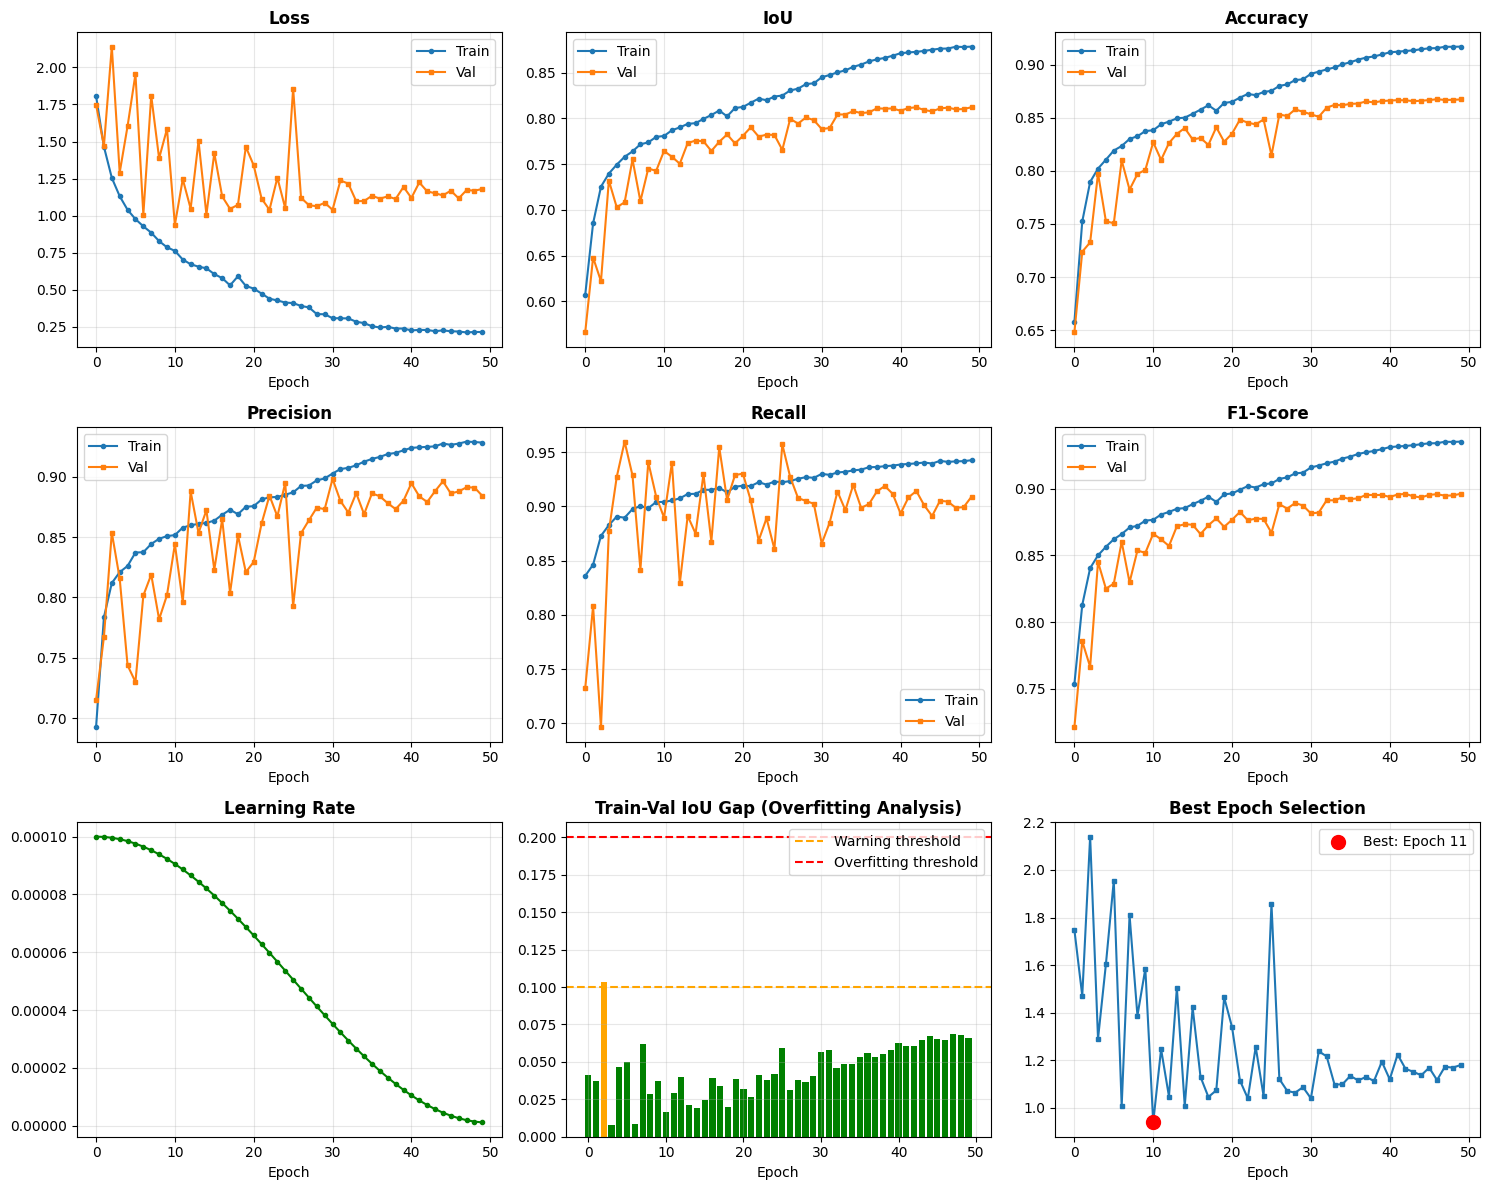

Best epoch: 11, Best val loss: 0.9385


In [17]:
# Cell 16: Comprehensive Training Visualization
def plot_training_history(history, save_dir):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    metrics = ['loss', 'iou', 'accuracy', 'precision', 'recall', 'f1_score', 'specificity']
    titles = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']

    for i, (m, t) in enumerate(zip(metrics[:6], titles[:6])):
        ax = axes[i//3, i%3]
        if m == 'loss':
            ax.plot(history['train_loss'], label='Train', marker='o', markersize=3)
            ax.plot(history['val_loss'], label='Val', marker='s', markersize=3)
        else:
            ax.plot([h[m] for h in history['train_metrics']], label='Train', marker='o', markersize=3)
            ax.plot([h[m] for h in history['val_metrics']], label='Val', marker='s', markersize=3)
        ax.set_title(t, fontweight='bold')
        ax.set_xlabel('Epoch'); ax.legend(); ax.grid(True, alpha=0.3)

    # Learning rate
    axes[2, 0].plot(history.get('lr', []), marker='o', markersize=3, color='green')
    axes[2, 0].set_title('Learning Rate', fontweight='bold')
    axes[2, 0].set_xlabel('Epoch'); axes[2, 0].grid(True, alpha=0.3)

    # Overfitting analysis (Train-Val gap)
    gap = [t - v for t, v in zip([h['iou'] for h in history['train_metrics']], [h['iou'] for h in history['val_metrics']])]
    axes[2, 1].bar(range(len(gap)), gap, color=['green' if g < 0.1 else 'orange' if g < 0.2 else 'red' for g in gap])
    axes[2, 1].axhline(y=0.1, color='orange', linestyle='--', label='Warning threshold')
    axes[2, 1].axhline(y=0.2, color='red', linestyle='--', label='Overfitting threshold')
    axes[2, 1].set_title('Train-Val IoU Gap (Overfitting Analysis)', fontweight='bold')
    axes[2, 1].set_xlabel('Epoch'); axes[2, 1].legend(); axes[2, 1].grid(True, alpha=0.3)

    # Best epoch marker
    best_epoch = np.argmin(history['val_loss'])
    axes[2, 2].plot(history['val_loss'], marker='s', markersize=3)
    axes[2, 2].scatter([best_epoch], [history['val_loss'][best_epoch]], color='red', s=100, zorder=5, label=f'Best: Epoch {best_epoch+1}')
    axes[2, 2].set_title('Best Epoch Selection', fontweight='bold')
    axes[2, 2].set_xlabel('Epoch'); axes[2, 2].legend(); axes[2, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'), dpi=150)
    plt.show()
    print(f'Best epoch: {best_epoch+1}, Best val loss: {history["val_loss"][best_epoch]:.4f}')

plot_training_history(history, CHECKPOINT_DIR)

Generating predictions: 100%|██████████| 28/28 [00:27<00:00,  1.03it/s]


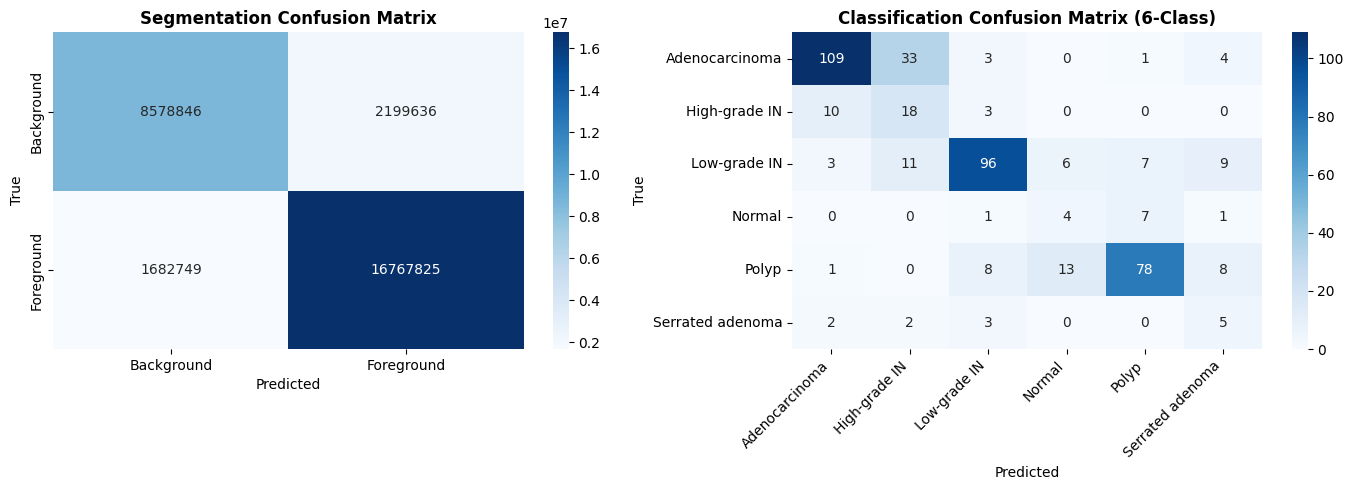

In [18]:
# Cell 17: Confusion Matrix Visualization
def plot_confusion_matrices(model, dataloader, device, class_names, save_dir):
    model.eval()
    all_seg_pred, all_seg_true = [], []
    all_cls_pred, all_cls_true = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Generating predictions'):
            images, masks, cls_idx = batch['image'].to(device), batch['mask'].to(device), batch['class_idx']
            outputs = model(images)
            seg_pred = (outputs['mask'] > 0.5).float().cpu().numpy().reshape(-1)
            seg_true = masks.cpu().numpy().reshape(-1)
            all_seg_pred.extend(seg_pred)
            all_seg_true.extend(seg_true)
            cls_pred = outputs['main_class'].argmax(dim=1).cpu().numpy()
            all_cls_pred.extend(cls_pred)
            all_cls_true.extend(cls_idx.numpy())

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Segmentation CM
    seg_cm = confusion_matrix(all_seg_true, all_seg_pred)
    sns.heatmap(seg_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
    axes[0].set_title('Segmentation Confusion Matrix', fontweight='bold')
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

    # Classification CM
    cls_cm = confusion_matrix(all_cls_true, all_cls_pred)
    sns.heatmap(cls_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title('Classification Confusion Matrix (6-Class)', fontweight='bold')
    axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'confusion_matrices.png'), dpi=150)
    plt.show()

CLASS_NAMES = ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp', 'Serrated adenoma']
plot_confusion_matrices(model, test_loader, DEVICE, CLASS_NAMES, CHECKPOINT_DIR)

Device: cpu

Loading model...
✅ Model loaded from epoch 50
  ✓ Adenocarcinoma: GT2001837-1-400-001.png
  ✓ High-grade IN: GT2012149-3-400-001.png
  ✓ Low-grade IN: GT1815555-6-400-001.png
  ✓ Normal: GT2000000-1-400-001.png
  ✓ Polyp: GT1815550-1-400-001.png
  ✓ Serrated adenoma: GT1815555-2-400-001.png

Visualizing 6  samples...

✅ Saved: c:\Users\PMLS\Desktop\FYP\visualization_results\correct_predictions_only.png


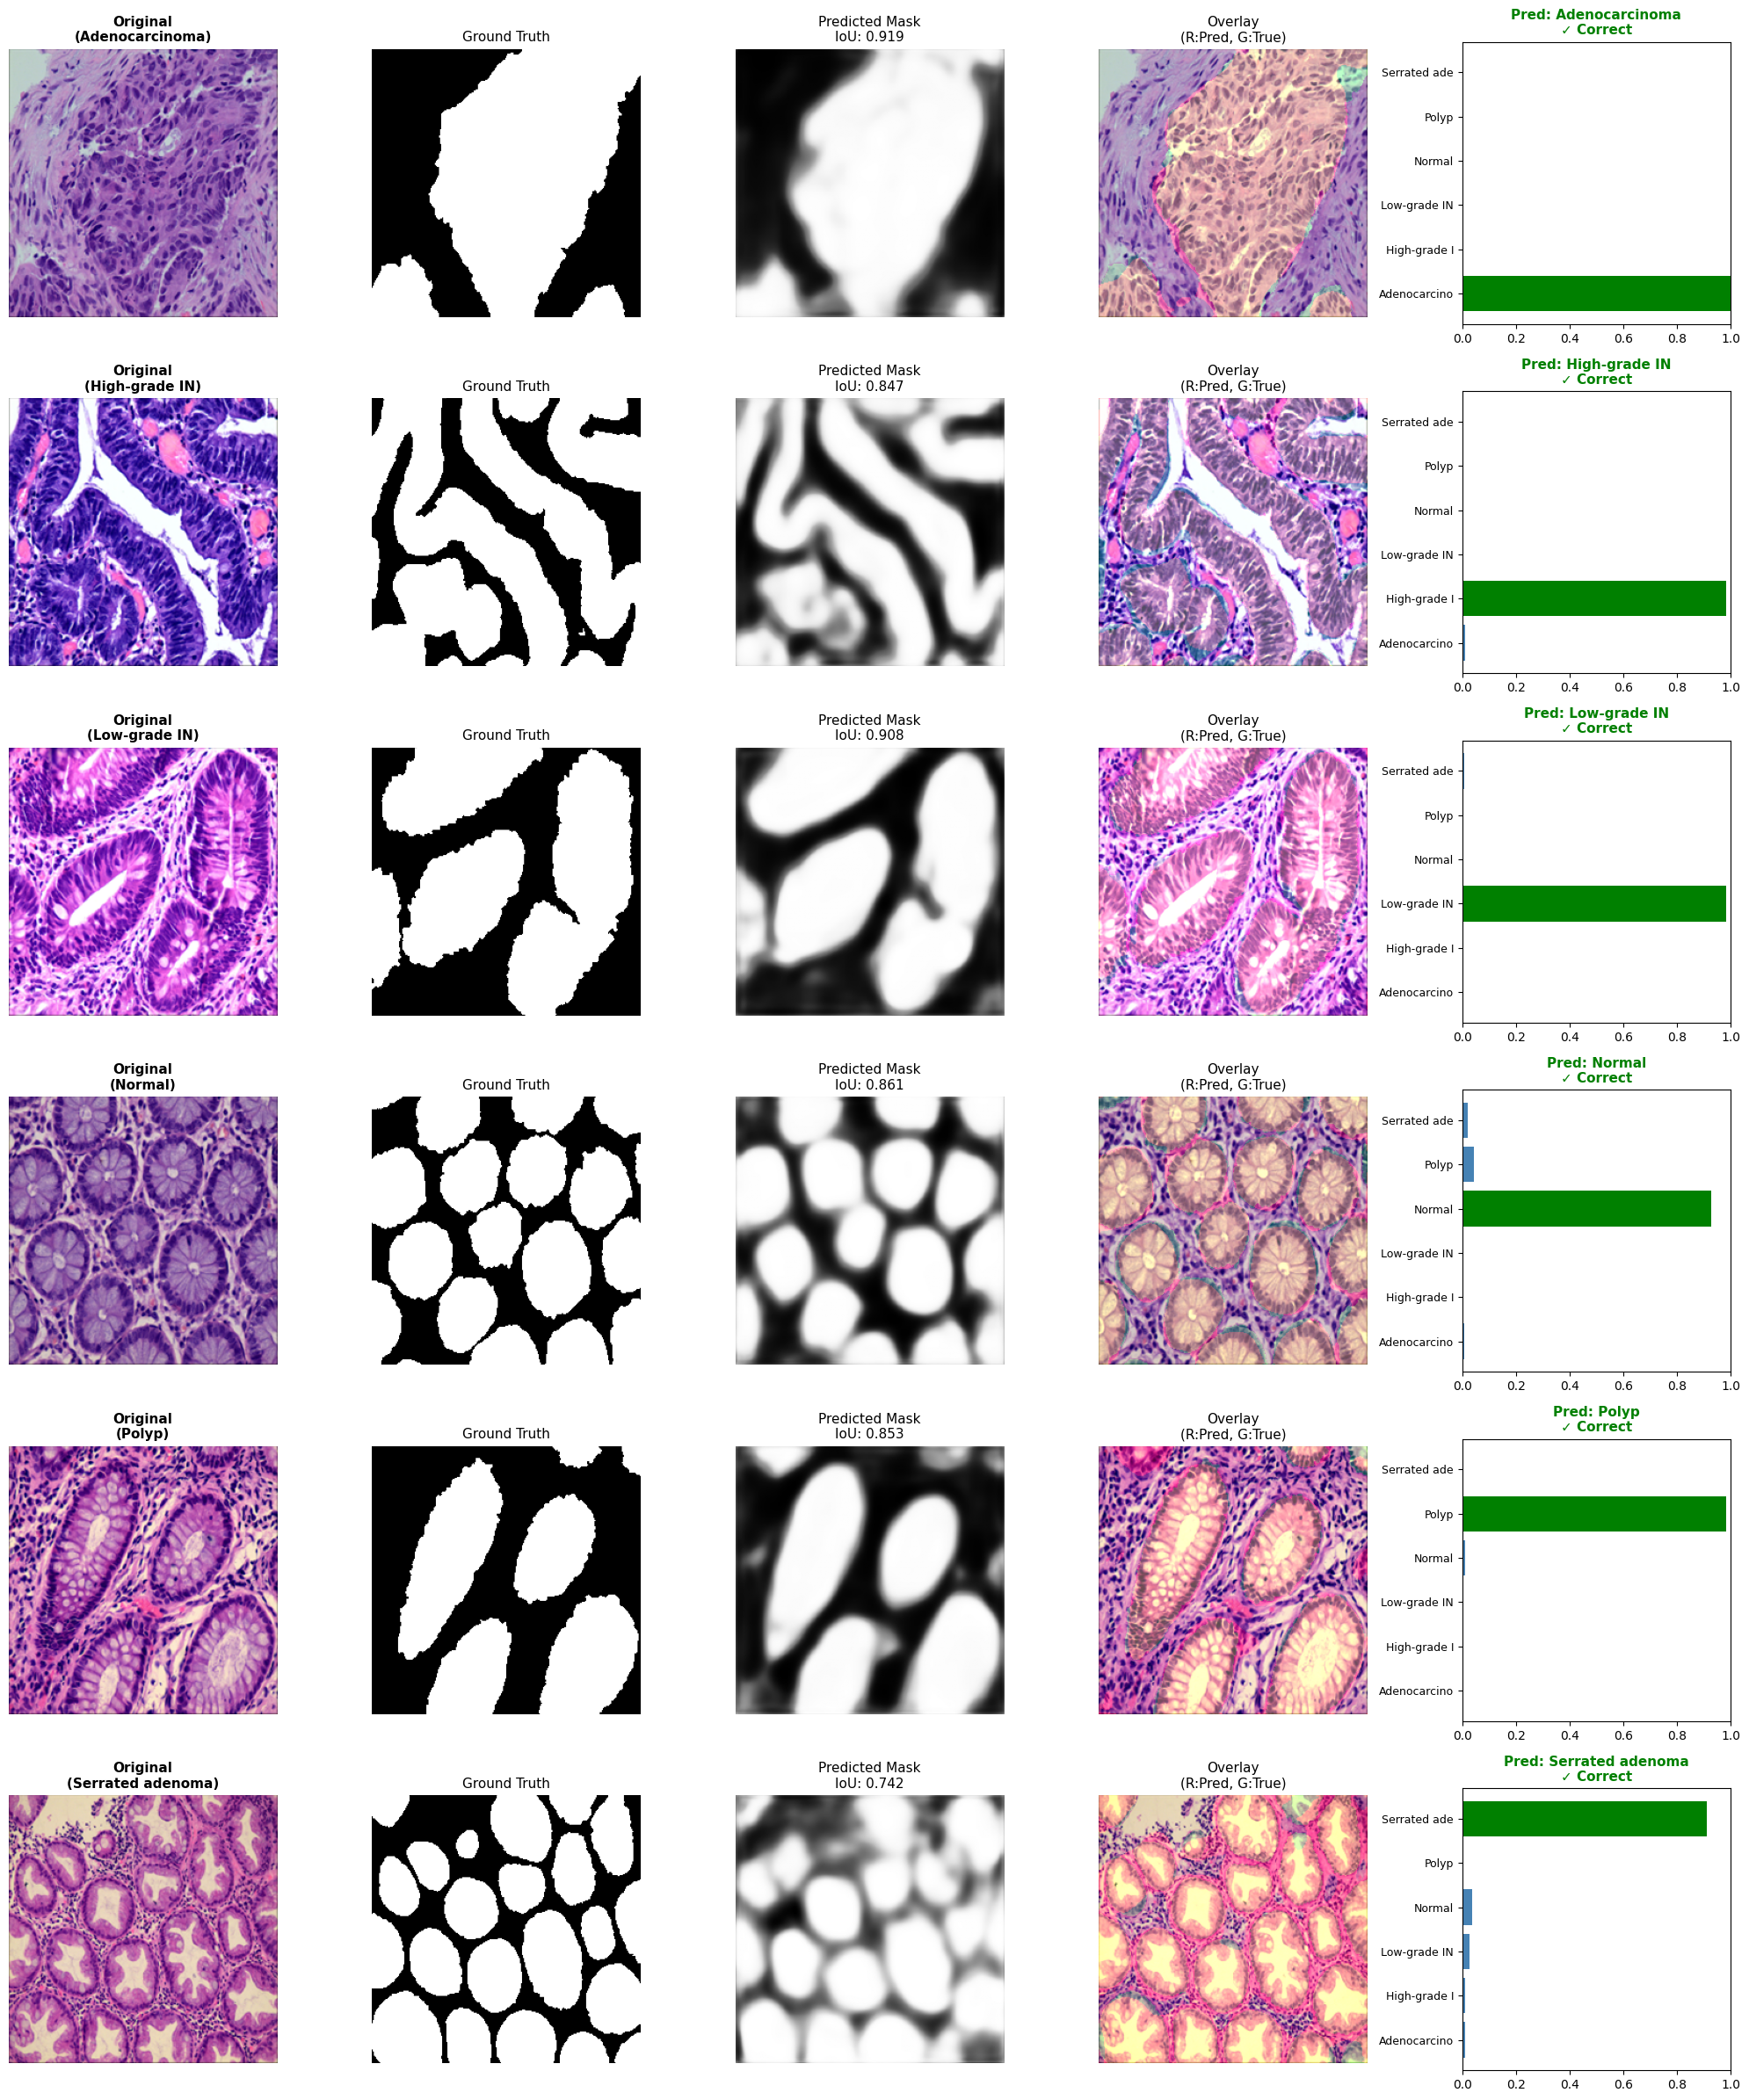


RESULTS SUMMARY 
Showing: 6/6 classes (all correctly classified)
Average IoU: 0.8550

Images used:
  Adenocarcinoma       | IoU: 0.919 | File: GT2001837-1-400-001.png
  High-grade IN        | IoU: 0.847 | File: GT2012149-3-400-001.png
  Low-grade IN         | IoU: 0.908 | File: GT1815555-6-400-001.png
  Normal               | IoU: 0.861 | File: GT2000000-1-400-001.png
  Polyp                | IoU: 0.853 | File: GT1815550-1-400-001.png
  Serrated adenoma     | IoU: 0.742 | File: GT1815555-2-400-001.png


In [1]:
# Cell 18: Sample Predictions Visualization
"""
INFERENCE SCRIPT - 1 SAMPLE PER CLASS

"""

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ============================================================================
# PATHS
# ============================================================================
DATA_DIR = r"c:\Users\PMLS\Desktop\FYP\EBHI-SEG"
CHECKPOINT_PATH = r"c:\Users\PMLS\Desktop\FYP\GOOGLE-DRIVE-NOTEBOOK-PLUS-RESULTS\latest_checkpoint.pth"
OUTPUT_DIR = r"c:\Users\PMLS\Desktop\FYP\visualization_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 256
CLASS_NAMES = ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp', 'Serrated adenoma']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        return self.proj(x).flatten(2).transpose(1, 2)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.scale = self.head_dim ** -0.5
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x), attn

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim), nn.Dropout(dropout)
        )
    def forward(self, x):
        x_attn, attn = self.attn(self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x, attn

class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768, depth=12, num_heads=12, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.blocks = nn.ModuleList([TransformerEncoder(embed_dim, num_heads, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1) + self.pos_embed
        attentions = []
        for block in self.blocks:
            x, attn = block(x)
            attentions.append(attn)
        return self.norm(x), attentions

class ExpertModule(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1), nn.BatchNorm2d(mid_ch), nn.ReLU(True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(True)
        )
    def forward(self, x): return self.conv(x)

class DynamicRouter(nn.Module):
    def __init__(self, channels, num_experts):
        super().__init__()
        self.router = nn.Sequential(
            nn.Conv2d(channels, channels//2, 3, padding=1), nn.BatchNorm2d(channels//2), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(channels//2, num_experts), nn.Softmax(dim=1)
        )
    def forward(self, x): return self.router(x)

class MixtureOfExperts(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, num_experts=4):
        super().__init__()
        self.experts = nn.ModuleList([ExpertModule(in_ch, mid_ch, out_ch) for _ in range(num_experts)])
        self.router = DynamicRouter(in_ch, num_experts)
    def forward(self, x):
        weights = self.router(x)
        outputs = torch.stack([e(x) for e in self.experts], dim=1)
        weights = weights.view(x.size(0), len(self.experts), 1, 1, 1)
        return (outputs * weights).sum(dim=1), weights.squeeze()

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(True)
        )
    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None: x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(in_ch, 256), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.net(x)

class MoEViTUNet(nn.Module):
    def __init__(self, img_size=256, patch_size=16, embed_dim=768, depth=12, num_heads=12, num_classes=6, num_experts=4):
        super().__init__()
        self.vit = VisionTransformer(img_size, patch_size, 3, embed_dim, depth, num_heads)
        self.patch_size, self.embed_dim = patch_size, embed_dim
        dims = [256, 128, 64, 32]
        self.conv_transform = nn.Conv2d(embed_dim, dims[0], 1)
        self.moe1 = MixtureOfExperts(dims[0], dims[0], dims[0], num_experts)
        self.moe2 = MixtureOfExperts(dims[0], dims[0], dims[1], num_experts)
        self.moe3 = MixtureOfExperts(dims[1], dims[1], dims[2], num_experts)
        self.moe4 = MixtureOfExperts(dims[2], dims[2], dims[3], num_experts)
        self.decoder1 = DecoderBlock(dims[0], dims[1])
        self.decoder2 = DecoderBlock(dims[1]*2, dims[2])
        self.decoder3 = DecoderBlock(dims[2]*2, dims[3])
        self.decoder4 = DecoderBlock(dims[3], dims[3])
        self.aux1 = AuxiliaryClassifier(dims[0], num_classes)
        self.aux2 = AuxiliaryClassifier(dims[1], num_classes)
        self.aux3 = AuxiliaryClassifier(dims[2], num_classes)
        self.aux4 = AuxiliaryClassifier(dims[3], num_classes)
        self.final_conv = nn.Conv2d(dims[3], 1, 1)
        self.main_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(dims[3], 256), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        vit_out, attns = self.vit(x)
        feat = vit_out[:, 1:, :]
        h = w = int(np.sqrt(feat.shape[1]))
        feat = feat.reshape(feat.shape[0], h, w, self.embed_dim).permute(0, 3, 1, 2)
        x0 = self.conv_transform(feat)
        x1, w1 = self.moe1(x0)
        x2, w2 = self.moe2(x1)
        x3, w3 = self.moe3(x2)
        x4, w4 = self.moe4(x3)
        d1 = self.decoder1(x1)
        x2_r = F.interpolate(x2, size=d1.shape[2:], mode='bilinear', align_corners=True) if d1.shape[2:] != x2.shape[2:] else x2
        d2 = self.decoder2(torch.cat([d1, x2_r], dim=1))
        x3_r = F.interpolate(x3, size=d2.shape[2:], mode='bilinear', align_corners=True) if d2.shape[2:] != x3.shape[2:] else x3
        d3 = self.decoder3(torch.cat([d2, x3_r], dim=1))
        d4 = self.decoder4(d3)
        d4_up = F.interpolate(d4, size=x.shape[2:], mode='bilinear', align_corners=True)
        return {
            'mask': torch.sigmoid(self.final_conv(d4_up)),
            'main_class': self.main_classifier(d4),
        }

# ============================================================================
# LOAD MODEL
# ============================================================================
print("\nLoading model...")
model = MoEViTUNet(img_size=IMG_SIZE, num_classes=6).to(DEVICE)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✅ Model loaded from epoch {checkpoint['epoch']+1}")

# ============================================================================
# FIND SAMPLES (1 per class)
# ============================================================================
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])


correct_samples = {}

for class_idx, class_name in enumerate(CLASS_NAMES):
    image_dir = os.path.join(DATA_DIR, class_name, 'image')
    mask_dir = os.path.join(DATA_DIR, class_name, 'label')
    
    if not os.path.exists(image_dir):
        continue
    
    
    for img_file in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        
        if not os.path.exists(mask_path):
            continue
        
        # Predict
        img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(img)
            pred_idx = out['main_class'].argmax(1).item()
        
        # Check if correct
        if pred_idx == class_idx:
            correct_samples[class_name] = {'image': img_path, 'mask': mask_path, 'file': img_file}
            print(f"  ✓ {class_name}: {img_file}")
            break
    
    if class_name not in correct_samples:
        print(f"  ✗ {class_name}: No correct sample found!")

# ============================================================================
# VISUALIZE  SAMPLES 
# ============================================================================
print(f"\nVisualizing {len(correct_samples)}  samples...")

fig, axes = plt.subplots(len(correct_samples), 5, figsize=(20, 4*len(correct_samples)))
row = 0
results = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    if class_name not in correct_samples:
        continue
    
    sample = correct_samples[class_name]
    
    # Load and predict
    img = transform(Image.open(sample['image']).convert('RGB')).unsqueeze(0).to(DEVICE)
    mask_true = (transform(Image.open(sample['mask']).convert('L')) > 0.5).float().squeeze().numpy()
    
    with torch.no_grad():
        out = model(img)
        mask_pred = out['mask'].cpu().squeeze().numpy()
        pred_idx = out['main_class'].argmax(1).item()
        probs = F.softmax(out['main_class'], dim=1).cpu().squeeze().numpy()
    
    # IoU
    intersection = ((mask_pred > 0.5) & (mask_true > 0.5)).sum()
    union = ((mask_pred > 0.5) | (mask_true > 0.5)).sum()
    iou = intersection / (union + 1e-8)
    
    # Display
    orig = np.array(Image.open(sample['image']).resize((256,256))) / 255.0
    
    axes[row,0].imshow(orig)
    axes[row,0].set_title(f'Original\n({class_name})', fontsize=11, fontweight='bold')
    axes[row,0].axis('off')
    
    axes[row,1].imshow(mask_true, cmap='gray')
    axes[row,1].set_title('Ground Truth', fontsize=11)
    axes[row,1].axis('off')
    
    axes[row,2].imshow(mask_pred, cmap='gray')
    axes[row,2].set_title(f'Predicted Mask\nIoU: {iou:.3f}', fontsize=11)
    axes[row,2].axis('off')
    
    overlay = orig.copy()
    overlay[...,0] = np.where(mask_pred > 0.5, np.clip(overlay[...,0]+0.3,0,1), overlay[...,0])
    overlay[...,1] = np.where(mask_true > 0.5, np.clip(overlay[...,1]+0.3,0,1), overlay[...,1])
    axes[row,3].imshow(overlay)
    axes[row,3].set_title('Overlay\n(R:Pred, G:True)', fontsize=11)
    axes[row,3].axis('off')
    
    # Classification bar
    axes[row,4].barh(range(6), probs, color=['green' if i==class_idx else 'steelblue' for i in range(6)])
    axes[row,4].set_yticks(range(6))
    axes[row,4].set_yticklabels([c[:12] for c in CLASS_NAMES], fontsize=9)
    axes[row,4].set_xlim(0, 1)
    axes[row,4].set_title(f'Pred: {CLASS_NAMES[pred_idx]}\n✓ Correct', fontsize=11, color='green', fontweight='bold')
    
    results.append({'class': class_name, 'iou': iou, 'file': sample['file']})
    row += 1

plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, 'correct_predictions_only.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"\n✅ Saved: {output_path}")
plt.show()

# Summary
print("\n" + "="*60)
print("RESULTS SUMMARY ")
print("="*60)
print(f"Showing: {len(results)}/6 classes (all correctly classified)")
print(f"Average IoU: {np.mean([r['iou'] for r in results]):.4f}")
print("\nImages used:")
for r in results:
    print(f"  {r['class']:20} | IoU: {r['iou']:.3f} | File: {r['file']}")


In [20]:
# Cell 19: Save Final Results
# Save training history as JSON
history_json = {
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'train_metrics': [{k: float(v) for k, v in m.items()} for m in history['train_metrics']],
    'val_metrics': [{k: float(v) for k, v in m.items()} for m in history['val_metrics']],
    'learning_rates': history.get('lr', [])
}
with open(os.path.join(CHECKPOINT_DIR, 'training_history.json'), 'w') as f:
    json.dump(history_json, f, indent=2)

# Final test evaluation
model.eval()
test_metrics = {k: 0 for k in ['accuracy','precision','recall','f1_score','iou','specificity']}
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch['image'].to(DEVICE))
        m = calculate_metrics(outputs['mask'], batch['mask'].to(DEVICE))
        for k in test_metrics: test_metrics[k] += m[k]
for k in test_metrics: test_metrics[k] /= len(test_loader)

print('\n' + '='*50)
print('FINAL TEST RESULTS')
print('='*50)
for k, v in test_metrics.items():
    print(f'{k.upper()}: {v:.4f}')

# Save test results
with open(os.path.join(CHECKPOINT_DIR, 'test_results.txt'), 'w') as f:
    f.write('='*50 + '\nFINAL TEST RESULTS\n' + '='*50 + '\n')
    for k, v in test_metrics.items():
        f.write(f'{k.upper()}: {v:.4f}\n')

print(f'\nAll results saved to: {CHECKPOINT_DIR}')
print('\n*** IMPORTANT: Download your checkpoints before the session ends! ***')


FINAL TEST RESULTS
ACCURACY: 0.8672
PRECISION: 0.8841
RECALL: 0.9090
F1_SCORE: 0.8961
IOU: 0.8121
SPECIFICITY: 0.7947

All results saved to: /content/drive/MyDrive/FYP_Checkpoints

*** IMPORTANT: Download your checkpoints before the session ends! ***
